In [ ]:
using ITensors, ITensorMPS, PythonPlot

# Global variables to store results
global C1zz = nothing
global C2zz = nothing
global C3zz = nothing
global L = 40

# Main computation
let
    # Create L Spin-1/2 Indices
    sites = siteinds("S=1/2", L)

    # Create the Hamiltonian (HI) of the Ising chain at its self-dual critical point from the O'Brien and Fendley paper.
    osI = OpSum()
    for j in 1:(L - 1)
        osI -= "X", j 
        osI -= "Z", j, "Z", j + 1
    end
    # Boundary terms
    osI -= "X", L
    osI -= "Z", L, "Z", 1
    HI = MPO(osI, sites)

    # Create the Hamiltonian (H3) of the three-spin interaction from the O'Brien and Fendley paper.
    os3 = OpSum()
    for j in 1:(L - 2)
        os3 += "X", j, "Z", j + 1, "Z", j + 2
        os3 += "Z", j, "Z", j + 1, "X", j + 2
    end
    # Boundary terms
    os3 += "X", L - 1, "Z", L, "Z", 1
    os3 += "X", L, "Z", 1, "Z", 2
    os3 += "Z", L - 1, "Z", L, "X", 1
    os3 += "Z", L, "Z", 1, "X", 2
    H3 = MPO(os3, sites)

    # Coupling coefficients for Exact G.S.
        lambdaI = 1
        lambda3 = 1
    
    #= Coupling coefficients for TCI such that lambda3 / lambdaI = 0.856
        lambdaI = 0.759685
        lambda3 = 0.650291
    =#

    # Adding the energy offset E0 to just one site
    EO = L * (lambdaI^2 + lambda3^2) / lambda3
    
    osEO = OpSum()
        osEO += EO, "Id", 1 # "Id" is the identity operator
    E0 = MPO(osEO, sites)

    # Full Hamiltonian from paper
    H = 2 * lambdaI * HI + lambda3 * H3 + E0

    # Create an initial random matrix product state
    psi0 = random_mps(sites)
    
    # Set the number of sweeps, bond dimensions, and cutoff for the DMRG algorithm
    nsweeps = 10
    maxdim = [10, 33, 66, 133, 200]
    mindim = [10, 22, 33, 66, 133]
    cutoff = 1.0e-10

    # Run the DMRG algorithm
    println("Maxdim per sweep: ", maxdim)
    println("Mindim per sweep: ", mindim)
    println()
    
    psis = [MPS() for i = 1:4]
    energies = zeros(4)


    energies[1], psis[1] = dmrg(H, psi0; nsweeps, mindim, maxdim, cutoff)
    for i = 2:4
        energies[i], psis[i] = dmrg(H, psis[1:i], psi0; nsweeps, mindim, maxdim, cutoff, weight = 100)
    end

    
    println()
    println("Final Energy 1 = $energy1")
    println("Final Energy 2 = $energy2")
    println("Final Energy 3 = $energy3")
    println("Final Energy 4 = $energy4")
    println()
    
    println("<psi1|psi1> = $(inner(psi1, psi1))")
    println()
    
    println("<psi1|psi2> = $(inner(psi1, psi2))")
    println("<psi1|psi3> = $(inner(psi1, psi3))")
    println("<psi1|psi4> = $(inner(psi1, psi4))")
    println("<psi2|psi3> = $(inner(psi2, psi3))")
    println("<psi2|psi4> = $(inner(psi2, psi4))")
    println("<psi3|psi4> = $(inner(psi3, psi4))")
    println()

    # Compute Z-Z correlation matrix for the first G.S. and store in global
    global C1zz = correlation_matrix(psi1, "Z", "Z")

    # Do the same for the second G.S.
    global C2zz = correlation_matrix(psi2, "Z", "Z")

    # And the third G.S.
    global C3zz = correlation_matrix(psi3, "Z", "Z")

    nothing
end

Maxdim per sweep: [10, 33, 66, 133, 200]

After sweep 1 energy=1.7342783866008915  maxlinkdim=4 maxerr=1.22E-15 time=0.045
After sweep 2 energy=1.2923707022274604  maxlinkdim=16 maxerr=4.50E-16 time=0.077
After sweep 3 energy=0.9093656348026229  maxlinkdim=49 maxerr=9.99E-11 time=0.379
After sweep 4 energy=0.0022050162017295495  maxlinkdim=70 maxerr=9.90E-11 time=1.569
After sweep 5 energy=8.048221074725907e-6  maxlinkdim=133 maxerr=1.23E-13 time=5.987
After sweep 6 energy=3.163932125409568e-8  maxlinkdim=133 maxerr=2.15E-14 time=7.894
After sweep 7 energy=2.7925120739737314e-10  maxlinkdim=133 maxerr=9.76E-16 time=6.983
After sweep 8 energy=1.0704403097237749e-12  maxlinkdim=133 maxerr=9.88E-16 time=7.364
After sweep 9 energy=-1.2275255371175449e-12  maxlinkdim=133 maxerr=6.28E-16 time=7.209
After sweep 10 energy=-9.00612917575927e-13  maxlinkdim=133 maxerr=3.43E-16 time=6.872
After sweep 1 energy=2.6180501383092967  maxlinkdim=4 maxerr=1.22E-15 time=0.066
After sweep 2 energy=1.28354

Max and Min Correlation for G.S. 1: 1.0000000000000004 and 6.22517204107336e-19

Max and Min Correlation for G.S. 2: 1.0 and 0.9999999999990202

Max and Min Correlation for G.S. 3: 1.0000000000000009 and 0.16572437158651795



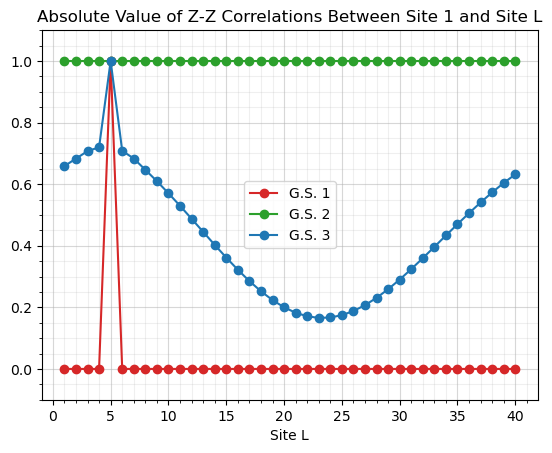

In [11]:
using PythonPlot

# Get the absolute values of correlations for all three G.S.
abs_C1zz = abs.(C1zz[5, :])
abs_C2zz = abs.(C2zz[5, :])
abs_C3zz = abs.(C3zz[5, :])

# Plot the Z-Z correlation between site 1 and site L for all three G.S.
x1 = collect(1:length(abs_C1zz))
plot(x1, abs_C1zz, marker="o", linestyle="-", color="tab:red", linewidth=1.5)

x2 = collect(1:length(abs_C2zz))
plot(x2, abs_C2zz, marker="o", linestyle="-", color="tab:green", linewidth=1.5)

x3 = collect(1:length(abs_C3zz))
plot(x3, abs_C3zz, marker="o", linestyle="-", color="tab:blue", linewidth=1.5)

legend(["G.S. 1", "G.S. 2", "G.S. 3"])
xlabel("Site L")
title("Absolute Value of Z-Z Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
    
# Adjusting graph to show the data better
ymax = max(maximum(abs_C1zz), maximum(abs_C2zz), maximum(abs_C3zz))
ymin = min(minimum(abs_C1zz), minimum(abs_C2zz), minimum(abs_C3zz))
ylim(ymin - 0.1, ymax + 0.1)
minorticks_on()
    
# Print max and min values for reference
println("Max and Min Correlation for G.S. 1: ", maximum(abs_C1zz), " and ", minimum(abs_C1zz))
println()
println("Max and Min Correlation for G.S. 2: ", maximum(abs_C2zz), " and ", minimum(abs_C2zz))
println()
println("Max and Min Correlation for G.S. 3: ", maximum(abs_C3zz), " and ", minimum(abs_C3zz))
println()